# SciFi Convention Maps

In an effort to determine the density of science fiction fans in Texas, I scraped data from Wikipedia's page "List of Science Fiction Conventions". https://en.wikipedia.org/wiki/List_of_science_fiction_conventions  

After slicing out the Texas conventions, I want to do a few things:  
*  I want to make a map with the convention locations, but some locations have multiple conventions.  This indicates that there is a higher number of scifi fans nearby to be able to support the higher convention rate, so I want to highlight this difference in locations.  
*  One would expect the conventions to fall primarily in the major cities, so to highlight the role of conventions in smaller towns, I want to find a way to normalize by the immediate population.  To do this, I will include a county-by-county map of Texas, scaling the number of conventions in a county by that county's population. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
from mpl_toolkits.basemap import Basemap
import pandas as pd
from pandas import DataFrame
from geopy.geocoders import Nominatim
%matplotlib inline

# City-by-City Data

In [3]:
condata=pd.read_csv('TexasCons.csv')

In [4]:
plotdata = condata.Location.value_counts()

In [5]:
plotdata

Dallas, Texas             4
Austin, Texas             2
College Station, Texas    1
Houston, Texas            1
McKinney, Texas           1
Name: Location, dtype: int64

#### As you see in the data above, some cities have multiple conventions.  To include this information, I will scale the map marker sizes by the number of conventions in that city.

In [6]:
placedict = dict(list(condata.groupby('Location')))

In [7]:
newlats = []
newlons = []
counties = []

In [8]:
for spot in plotdata.keys():
    mess = list(placedict[spot].Coordinates)
    cmess = list(placedict[spot].County)
    counties.append(cmess[0])
    sep = mess[0].strip('[]').split(',')
    newlats.append(sep[0])
    newlons.append(sep[1])

In [9]:
df = DataFrame(plotdata, index=[plotdata.keys()])

In [10]:
df['Lat']=newlats
df['Long']=newlons
df['County']=counties

In [11]:
df

,Location,Lat,Long,County
"Dallas, Texas",4,32.7762719,-96.7968558,Dallas
"Austin, Texas",2,30.2711286,-97.7436994,Travis
"College Station, Texas",1,30.6262616,-96.3347248,Brazos
"Houston, Texas",1,29.7589382,-95.3676973,Harris
"McKinney, Texas",1,33.1976496,-96.615447,Collin


In [12]:
cpalette = DataFrame({'darker': [50,256,150], 'dark':[13,177,75], 'med':[107,192,113], 'light':[157,210,155],'pale':[204,230,202]}, index=['R','G','B'])

In [13]:
lllat = 25; urlat = 37; lllon = -107; urlon = -93

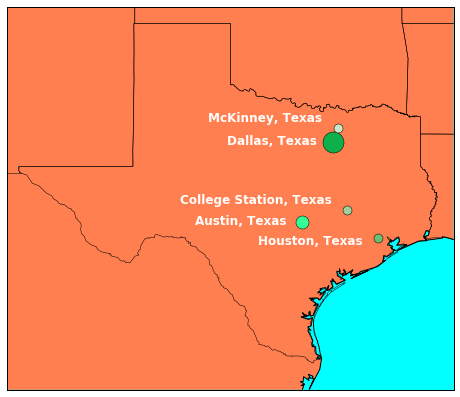

In [14]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
map = Basemap(ax=ax,lon_0=(urlon+lllon)/2, lat_0=(urlat+lllat)/2, 
            llcrnrlat=lllat, urcrnrlat=urlat,llcrnrlon=lllon,urcrnrlon=urlon,resolution='l')
map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='coral',lake_color='aqua',zorder=0)
map.drawcoastlines()
map.readshapefile('./states_21basic/states','states')
#Shapefile from https://www.arcgis.com/home/item.html?id=f7f805eb65eb4ab787a0a3e1116ca7e5
for i,loc in enumerate(df.index):
    x = float(df.Long[i])
    y = float(df.Lat[i])
    r, g, b = cpalette.iloc[:,i]/256
    size = 5 + df.Location[i]*4
    map.plot(x,y,marker='o',color=[r,g,b],ms=size)
    
    tx = float(df.Long[i])-0.5
    ty = float(df.Lat[i])-0.2
    if i == 2 or i == 4:  ty = ty + 0.3
    if i == 3:  ty = ty - 0.1
    plt.text(tx, ty, df.index[i],fontsize=12,fontweight='bold',
                    ha='right',va='bottom',color='w')
plt.savefig('TexasCons.jpg',bbox_inches='tight')

Not surprisingly, the Dallas area has the most conventions, especially if you include McKinney's data point.  (McKinney is about a 20 minute drive from downtown Dallas in light traffic.)  This could either mean that there is a high density of scifi fans there to support so many conventions, or that these particular fans have more time and money to attend conventions.

On the other hand, given that Houston is a much bigger city than Austin, I am a little surprised that there are more scifi conventions in Austin.  It could be that Austin's tech scene engenders a more scifi-prone population than Houston.

# County-by-County Data

Now, to do the county colors, I need more data with the county populations.  I was able to find this data at the state demographer's website. (Did you know there's a state demographer?  Neat!)  http://osd.texas.gov/Data/TPEPP/Estimates/  

I used the most recent estimates of county populations available, which are for Jan 2014 (included in the 2013 report).

In [15]:
countypop = pd.read_csv('2013_txpopest_county.csv')

In [16]:
pop = []
for cou in df['County']:
    for i,line in enumerate(countypop.county):
        if cou == line: pop.append(countypop.jan1_2014_pop_est[i])

In [17]:
df['Pop']=pop

In [18]:
df

,Location,Lat,Long,County,Pop
"Dallas, Texas",4,32.7762719,-96.7968558,Dallas,2474550
"Austin, Texas",2,30.2711286,-97.7436994,Travis,1126684
"College Station, Texas",1,30.6262616,-96.3347248,Brazos,204362
"Houston, Texas",1,29.7589382,-95.3676973,Harris,4365601
"McKinney, Texas",1,33.1976496,-96.615447,Collin,867308


#### Because the population numbers are so large, I will scale the number of conventions by how many millions of people populate that county.

In [19]:
divpop = df.Location/df.Pop*1e6

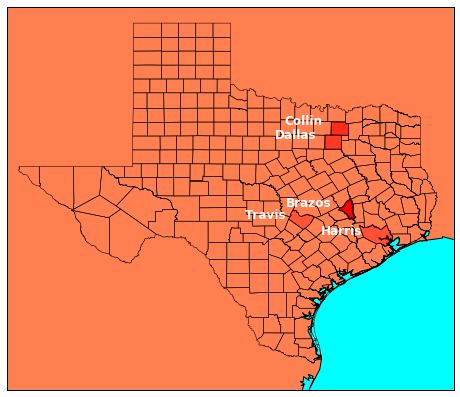

In [27]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
lllat = 25; urlat = 37; lllon = -107; urlon = -93
map = Basemap(ax=ax,lon_0=(urlon+lllon)/2, lat_0=(urlat+lllat)/2, 
            llcrnrlat=lllat, urcrnrlat=urlat,llcrnrlon=lllon,urcrnrlon=urlon,resolution='l')
map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='coral',lake_color='aqua',zorder=0)
map.drawcoastlines()
map.readshapefile('./Counties/Counties', 'counties',zorder=3)

patches   = []
patchlist = []

for info, shape in zip(map.counties_info, map.counties):
    for i,couname in enumerate(df.County):
        if info['Name'] == couname and info['Name'] not in patchlist:
            patchlist.append(info['Name'])
            patches.append( Polygon(np.array(shape), True) )
            scale = df.Location[i]/df.Pop[i]*1e6/max(divpop)
            patch = PatchCollection(patches, facecolors='r', edgecolor='k', linewidths=1., zorder=10)
            patch.set_alpha(0.9*scale)
            ax.add_collection(patch)
            
            tx = float(df.Long[i])-0.5
            ty = float(df.Lat[i])
            plt.text(tx, ty, df.County[i],fontsize=12,fontweight='bold', ha='right',va='bottom',color='w')
plt.savefig('TexasCoCons.jpg',bbox_inches='tight')

When populations are taken into account, you can really see how that College Station convention stands out.  Their 0.2 million people are far fewer than required for most locations to support a convention, so they are comparatively rich in convention opportunities compared to similar less-populous locations.  However, Texas A&M University is in College Station, and its student population is likely not counted in the county population unless their parents also live in Brazos County.  As of 2015, the student population of Texas A&M was 58,000+ so that adds another 25% to the Brazos County population which I'm sure helps fill out the convention.

# US Data

Since the original Wikipedia page included many more conventions than just those in Texas, I decided to expand my scope and look at the locations of conventions across the country.  I'll replicate the first Texas map but with the whole US.

In [21]:
USdata=pd.read_csv('USACons.csv')

In [22]:
USdata.columns=['ind','Conv','Loc','USA','type','web','date']

In [23]:
USdata[:5]

,ind,Conv,Loc,USA,type,web,date
0,2,AggieCon,"College Station, Texas",USA,General,http://aggiecon.tamu.edu/,2016-04-01
1,3,Albacon,"Albany, New York",USA,SF/F,http://www.albacon.org/,2016-03-04
2,4,All-Con,"Dallas, Texas",USA,General,http://www.all-con.net,2016-03-17
3,5,ApolloCon,"Houston, Texas",USA,General,http://www.apollocon.org,2015-06-19
4,6,Archon,"St. Louis, Missouri",USA,General,http://www.archonstl.org/,2015-10-02


In [24]:
USplotdata = USdata.Loc.value_counts()

In [25]:
geolocator = Nominatim()

In [32]:
USlon = []
USlat = []
for spot in USplotdata.keys():
    if 'Various' in spot:
        USlat.append('')
        USlon.append('')
    else:
        location = geolocator.geocode(spot,timeout=None)
        USlat.append(location.latitude)
        USlon.append(location.longitude)

KeyboardInterrupt: 

In [ ]:
USdf = DataFrame(USplotdata, index=[USplotdata.keys()])
USdf['Lat'] = USlat
USdf['Lon'] = USlon

In [ ]:
lat_1 = 25; lat_2 = 50; lon_0 = -97; lat_0 = 38.88

In [ ]:
fig2 = plt.figure(figsize=(20,20))
ax = fig2.add_subplot(111)
m = Basemap(width=4750000,height=3000000,
            resolution='l',projection='aea',\
            lat_1=lat_1,lat_2=lat_2,lon_0=lon_0,lat_0=lat_0)
m.drawmapboundary(fill_color='blue')
m.fillcontinents(color='g',lake_color='blue',zorder=0)
m.drawcoastlines()
m.drawcountries()
m.readshapefile('./states_21basic/states','states')
for i,loc in enumerate(USdf.index):
    if 'Various' not in loc:
        x, y = m(float(USdf.Lon[i]),float(USdf.Lat[i]))
        size = 5 + USdf.Loc[i]*3.5
        m.plot(x,y,marker='o',color='aqua',ms=size)
        if USdf.Loc[i] > 1:
            tx, ty = m(float(USdf.Lon[i])-0.5, float(USdf.Lat[i])-0.2)
            if 'Boston' in USdf.index[i] or 'Dearborn' in USdf.index[i]:  ty = ty + 70000
            if 'Atlanta' in USdf.index[i] or 'Memphis' in USdf.index[i]:  ty = ty - 60000
            if 'Angeles' in USdf.index[i]:
                tx = tx + 300000
                ty = ty + 50000
            plt.text(tx, ty, USdf.index[i],fontsize=12,fontweight='bold',
                    ha='right',va='bottom',color='w')
plt.savefig('USAcons.pdf',bbox_inches='tight')

In this map, I have plotted every scifi convention by location, with the size of the markers indicating number of conventions held in that location.  Any location that has multiple conventions was also labeled.  

Hello, Atlanta!  Who knew it was such a massive hub for scifi conventions?  Also, because several conventions are held in suburbs of major cities, the size of the markers doesn't directly indicate the available conventions for those locations, such as Minneapolis, Chicago, and Boston.  However, you can see we've actually got it pretty good in Texas.  Unless you live in Maryland, Texas has a great diversity of scifi convention locations as well as multiple locations with more than one convention.  Not all of these conventions happen every year, but a great many of them do, so that's a boon to Texan scifi fans!  